# Implementing and Parallelizing ADAPT-VQE
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

[Adaptive Derivative-Assembled Pseudo-Trotter VQE (ADAPT-VQE)](https://www.nature.com/articles/s41467-019-10988-2) is a variational hybrid quantum-classical algorithm with many benefits over traditional VQE. This lab is an exploration of ADAPT-VQE and how it can be implemented using CUDA-Q.

**What you will do:**
- Learn the concepts behind the ADAPT approach
- Explore the importance of selecting good operator pools
- Write the quantum kernels and main workflow for ADAPT-VQE
- Parallelize multiple parts of the code and simulate running it on multiple GPUs
- Learn how CUDA-Q Solvers make using ADAPT-VQE pleasantly simple

**CUDA-Q Syntax you will use:**
-  methods for CUDA-Q `kernel` construction including state passing
- `observe` and `get_state` to evaluate kernels
- The `mqpu` backend, the associated `observe_async` and `get_state_async` functions, and `get`.
- `exp_pauli` to dynamically construct quantum circuits from CUDA-Q Spin Operators
- CUDA-Solver's ` solvers.adapt_vqe` and `create_molecule` functions.

**Prerequisites:**
This lab assumes you have a basic understanding of quantum algorithms and understand the standard VQE workflow. If you need a refresher, check out the "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" series to learn how to code a variational algortim with CUDA-Q from scratch and check out [this tutorial](https://nvidia.github.io/cuda-quantum/latest/applications/python/vqe_advanced.html) for more details about VQE. This lab focuses on a chemistry application, so some knowledge of chemistry terminology is helpful but not required.  All exercises emphasize the quantum computing concepts rather than the chemistry.

💻 Just a heads-up: This notebook is designed to be run on an environment with a GPU. If you don't have access to a GPU, feel free to read through the cells and explore the content without executing them. Enjoy learning! ⭐

 Before we get started, execute the cells below to load the required packages.

In [ ]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/chemistry-simulations/Images ./Images
#!mv cuda-q-academic-main/chemistry-simulations/aux_files ./aux_files

In [ ]:
# If you are working in an environment that does not have cudaqx installed, 
# uncomment the code below to install cudaq-solvers and the required dependencies.  
# Then restart the kernel before executing the next cell.
#!sudo apt-get update && sudo apt-get install -y gfortran
#!pip install cudaq-solvers -q


In [1]:
import cudaq, cudaq_solvers as solvers
from aux_files.krylov.qchem.classical_pyscf import get_mol_hamiltonian
cudaq.set_target('nvidia', option='mqpu,fp64')
import numpy as np
from cudaq import spin
from typing import List
from scipy.optimize import minimize
import time
from aux_files.krylov.qchem.operator_pool import get_uccsd_pool


# ADAPT-VQE algorithm

The variational quantum eigensolver (VQE) is a well known quantum chemistry technique, which estimates the ground state of a molecule by optimizing a parameterized ansatz through iterative loops involving expectation values computed on a QPU and classical parameter updates performed by a supercomputer.  VQE suffers from a a number of issues including costly sampling of the Hamiltonian terms, and the so called barren plateau problem where even modest problems sizes do not converge due to the flat optimization landscape.

For VQE to have any viability for near term applications, clever implementations are necessary to avoid these challenges. One promising approch is the Adaptive Derivative-Assembled Pseudo-Trotter VQE (ADAPT-VQE) approach. The core idea is rather than have a fixed ansatz, to "adaptively" build the ansatz over the course of the algorithm by performing the following steps: 

1. On classical hardware, compute the one and two-electron integrals and transform the Hamiltonian to a qubit representation.
2. Build an operator pool, usually corresponding to physical excitations from techniques like unitary coupled cluster with singles and doubles (UCCSD).
3. Initialize qubits in a reference Hatree Fock state.
4. Measure the commutator of the Hamiltonian with each operator in the operator pool to compute the gradient.
5. If the norm of the gradient is below a threshold, then exit.  Otherwise, add the operator with the largest gradient contribution along with a new variational parameter, $\theta_{i+1}$.
6. Run VQE on this circuit to obtain optimized variational parameters.
7. Repeat steps 4 through 6 until convergence.

All of the steps are represented below in the following figure.

<img src="Images/adapt_vqe/adapt_workflow.png"  title="Landscape Image" width="1300">


If you are a careful reader, this may seem like a we are now running an entire VQE experiment for each iteration.  This is correct, but, the additive constructions of the ansatz means that we begin with very simple and easy to optimize circuits relative to a starting a VQE procedure with a fixed ansatz with many circuit parameters. Using the gradient allows strategic operator selection so we are optimizing parameters for operators more likely to converge to the ground state. Adding new parameters one at a time to an already converged solution allows each iteration to begin with a warm start.  In practice, ADAPT-VQE generally converges faster than VQE and is more resilient to barren plateaus given this warm start.  

To get a better sense of the process for ADAPT-VQE and how it compares with VQE, try the following interactive widget linked below.  The data is artificial, but is qualitatively representative of the two approaches.

<iframe src="https://nvidia.github.io/cuda-q-academic/chemistry-simulations/Images/adapt_widget.html" width="800" height="600"></iframe>


The original paper for ADAPT-VQE entitled ["An adaptive variational algorithm for exact molecular simulations on a quantum computer"](https://www.nature.com/articles/s41467-019-10988-2) presents data (figure below) that demonstrates the performance benefits of the ADAPT approach.  The chart below shows the convergence of different ansatz construction techniques compared to ADAPT as a function of variational parameters for BeH.  ADAPT converges much faster and with far fewer parameters.  

<img src="Images/adapt_vqe/adapt_convergence.png"  title="Adapt VQE Convergence" width="500">


The standard UCCSD ansatz is noted in the plot as having nearly twice the number of parameters as ADAPT as well as much worse convergece.

The rest of this lab will walk you though coding up an ADAPT-VQE implementation.  You will explore the impact of different operator pools as well as learn how ADAPT is well suited for parallelization across multiple QPUs.


## Building the Operator Pool and Computing the Gradient

Before building the entire workflow, it is helpful to construct some of the subroutines. You will begin by creating subroutines to define the operator pool and to compute the gradient.  First, consider the operator pool. Any Pauli word could be placed in the operator pool. An operator $A_i$ can then be selected and applied to a quantum circuit as $e^{-i\theta_iA_i}$ to build a parameterized quantum circuit ansatz. For traditional VQE, the same procedure is used, except all of the operators are applied *a priori* to construct a fixed parametrized ansatz.

Naively one might think that a bigger and more diverse operator pool is inherently better. However, because quantum chemistry has certain symmetries, many operators would be poor choices and even violate physical constraints of the system.

A common choice of operators ubiquitous in chemistry  comes from unitary coupled cluster with single and double excitations (UCCSD). Where single excitations are defined as:

$$ T_{ij} = \frac{i}{2}(X_iY_j - Y_iX_j)\prod_{p=i+1}^{j-1} Z_p $$

And double excitations as:

$$ T_{ijkl} = \frac{i}{8}(X_iY_jX_kX_l +Y_iX_jX_kX_l + Y_iY_jY_kX_l + Y_iY_jX_kY_l - X_iX_jY_kX_l - X_iX_jX_kY_l - Y_iX_jY_kY_l - X_iY_jY_kY_l) \prod_{p=i+1}^{j-1} Z_p \prod_{r=k+1}^{l-1} Z_r $$


**Exercise 1:** 

This exercise will allow you to explore some of the reasons why poor selection of an operator pool can lead to convergence issues with ADAPT-VQE.

We've demonstrated how to create an $H_2$ molecule using `solvers`.  Your task is to 
prepare a Hartree Fock kernel. 
The second part of this exercise is to write one more kernel that applies $T_{0123}$ to the Hartree Fock state. To help guide you, we've created a kernel that applies  $Z_0Z_1Z_2Z_3$ as an example using `exp_pauli` where the coefficient is a variational parameter. 

Run VQE and comment on the results.


{'nuclear_energy': 0.7080240981000804, 'hf_energy': -1.116325564486115, 'fci_energy': -1.1371757102406854}
(-0.106477+0i) + (0.17028+0i) * Z0 + (0.17028+0i) * Z1 + (-0.220041+0i) * Z2 + (-0.220041+0i) * Z3 + (0.1202+0i) * Z0Z2 + (0.168336+0i) * Z0Z1 + (0.0454063+0i) * Y0X1X2Y3 + (-0.0454063+0i) * Y0Y1X2X3 + (-0.0454063+0i) * X0X1Y2Y3 + (0.0454063+0i) * X0Y1Y2X3 + (0.165607+0i) * Z0Z3 + (0.1202+0i) * Z1Z3 + (0.165607+0i) * Z1Z2 + (0.174073+0i) * Z2Z3
Initial Energy: -1.1163255644861154
Energy: -1.1163255644861154


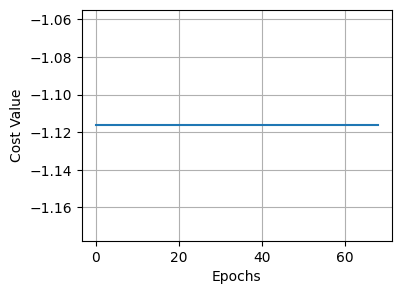

[0.5]
Initial Energy: -0.042406687590035436
Energy: -1.1371757102406852


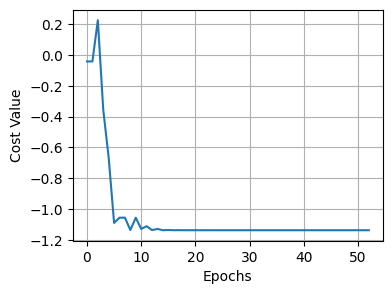

[0.37841193]
Initial Energy: -1.1163255644861154
Energy: -1.1163255644861154


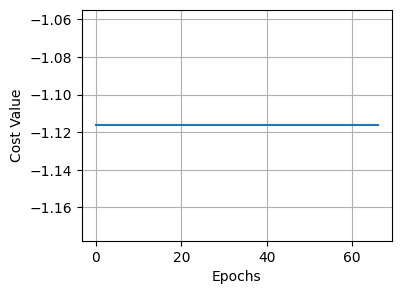

[0.5]


In [ ]:
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, casci=True)

norbitals = molecule.n_orbitals
nelectrons = molecule.n_orbitals
print(molecule.energies)
print(molecule.hamiltonian)


#TODO START
@cudaq.kernel # HF kernel
def kernel(theta: List[float]):
    reg = cudaq.qvector(4)
    
    #FIX_ME# # Initialize the first two qubits in the one-state


@cudaq.kernel # T0123 kernel
def kernel_a(theta: List[float]):
    reg = cudaq.qvector(4)
    
    #FIX_ME# # Initialize the first two qubits in the one-state, then applly T0123

    

@cudaq.kernel # Z0Z1Z2Z3 example kernel
def kernel_b(theta: List[float]):
    reg = cudaq.qvector(4)
    
    x(reg[0])
    x(reg[1]) # Initialize the first two qubits in the one-state
    exp_pauli(theta[0], reg, "ZZZZ")   


kernel_list = [kernel, kernel_a, kernel_b]
#TODO END


for k in kernel_list:
    cost_values = []
    
    def cost(parameters):
    
        expectation_value = cudaq.observe(k, molecule.hamiltonian,
                                          parameters).expectation()
        cost_values.append(expectation_value)
    
        return expectation_value

    initial_parameters = [0.5]
    initial_cost_value = cost(initial_parameters)
    print("Initial Energy:", initial_cost_value)

    
    result = minimize(cost,
                      initial_parameters,
                      method='Nelder-Mead', options={'xatol':1e-8, 'fatol':1e-12, 'maxiter':300})

    print("Energy:", result.fun)

    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(4, 3))
    
    x_values = list(range(len(cost_values)))
    y_values = cost_values
    
    plt.plot(x_values, y_values)
    plt.xlabel("Epochs")
    plt.ylabel("Cost Value")
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
    
    print(result.x)

The reason the $Z_0Z_1Z_2Z_3$ operator did not work, is that it commutes with the Hamiltonian. This means that it has no impact on the expectation value and is therefore a useless addition to an operator pool, potentially adding to the circuit depth with no gain in accuracy. Confirm this below by computing its commutator with the Hamiltonian:

$$ [H,A] = HA -AH $$

In [ ]:
zzzz_operator = spin.z(0)*spin.z(1)*spin.z(2)*spin.z(3)
print("Commutator:", molecule.hamiltonian*zzzz_operator - zzzz_operator*molecule.hamiltonian)

Another potential issue is adding an operator that breaks a symmetry like the number of electrons.  Even if such an operator lowered the energy, you no longer have a solution for the molecule in question.  

Use the number operator $N = 2*I - \frac{1}{2}(Z_0 + Z_1 + Z_2 + Z_3)$ to compute $\bra{\psi}N\ket{\psi}$ and prove that $Z_0Z_1X_2 +Z_0Z_1Y_2$ produces states that have more than 2 electrons.

In [ ]:
# TODO start
number_operator = 2 * spin.i(0)*spin.i(1)*spin.i(2)*spin.i(3) - 0.5*spin.z(0) - 0.5*spin.z(1) - 0.5*spin.z(2) - 0.5*spin.z(3)

@cudaq.kernel # HF operator
def kernel():
    reg = cudaq.qvector(4)
    
    #FIX_ME# # Initialize the first two qubits in the one-state


@cudaq.kernel 
def kernel_c():
    reg = cudaq.qvector(4)
    
    #FIX_ME# # Initialize the first two qubits in the one-state, then applly Z_0Z_1X_2 +Z_0Z_1Y_2 

print("Particle Number HF:", cudaq.observe(kernel, number_operator).expectation())
print("Particle Number:", cudaq.observe(kernel_c, number_operator).expectation())
# TODO End

Particle Number HF: 2.0
Particle Number: 2.3540367091367855


Auxiliary scripts in CUDA-Q make it easy to build a standard operator pool using a function like `get_uccsd_pool` to provide a list of spin operators corresponding to all UCCSD excitations. The code also splits each operator into a list of Pauli words (`word_pool`) and a list of the associated coefficients (`sign_pool`).   

This section of code also includes a function to compute the commutator operator for each element in the full operator pool. Note, that the factor of `i` was removed from each operator to make data transfer into CUDA-Q kernels easier, but it is included in the commutator function below for accuracy.

In [5]:
n_qubits= norbitals * 2

pools,word_pool,sign_pool = get_uccsd_pool(nelectrons, n_qubits)

print('Number of operator pool: ', len(pools))
print('Word Pool: ', word_pool)
print('Sign Pool: ', sign_pool)


def commutator(pools, ham):
    com_op = []
    
    for i in range(len(pools)):
        # We add the imaginary number that we excluded when generating the operator pool.
        op = 1j * pools[i]
        
        com_op.append(ham * op - op * ham)
         
    return com_op
        
grad_op = commutator(pools, molecule.hamiltonian)

Number of operator pool:  3
Word Pool:  [['YZXI', 'XZYI'], ['IYZX', 'IXZY'], ['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']]
Sign Pool:  [[(0.5+0j), (-0.5-0j)], [(0.5+0j), (-0.5-0j)], [(0.125+0j), (0.125+0j), (0.125+0j), (0.125+0j), (-0.125-0j), (-0.125-0j), (-0.125-0j), (-0.125-0j)]]


## Preparing $\ket{\psi}$ Kernels

So far, you have completed a number of the prerequisite functions required to construct the ADAPT-VQE workflow. The figure below shows green checks for these already completed items.  You will now focus on the yellow boxes where a state $\ket{\psi}$ is prepared from which the gradient $\bra{\psi}[H,A]\ket{\psi}$ is computed.  

<img src="Images/adapt_vqe/workflow_middle.drawio.png"  title="Adapt VQE Workflow Progress" width="1300">


Working backwards, the simple kernel below takes advantage of CUDA-Q's state passing capabilites to build a kernel constructed from an arbitrary state vector.  Such an abstraction is helpful as it allows easy separation from an initial state kernel (the Hartree Fock state) and the resulting kernel from each ADAPT-VQE iteration.  Regardless of the origin, `cudaq.get_state()` can be used to extract the state vector which will be input to the kernel `psi` to initialize the next iteration.

In [6]:
@cudaq.kernel
def psi(state:cudaq.State):
    q = cudaq.qvector(state)

**Exercise 2:**

You will now construct the two sorts of kernels which will be used to construct input states for `psi`.  
1. A kernel which prepares the Hartree Fock state
2. A kernel which applies all operators selected from the previous ADAPT-VQE iterations on the Hartree Fock state.

The second kernel is the tricky one here as the kernel must receive a number of inputs in order to apply the selected operators and their optimized $\theta$'s. CUDA-Q kernels require inputs to be simple typed lists consisting of strings, integers, or floats.  This may seem inconvenient, but is an important aspect of ensuring kernels are lightweight and result in high performance computations.  Thus, it is easiest to break the input operators into separate lists corresponding to the coefficients, and Pauli words of the singles and doubles operators, respectively.    

The kernel definition is provided for you below.  Fill in the appropriate code to apply all of the operators selected from the ADAPT-VQE process. Hints: 
* Consider two separate loops, one for applying the singles operators and one for applying the doubles, each starting from a flattened list of all operators.
* Assume the theta list contains the parameters corresponding to the singles operators followed by the doubles operators sorted by the order in which they were added.
* Also, do not forget to initialize the Hartree Fock state.

In [ ]:
# Write a kernel to prepare the HF reference state 
@cudaq.kernel
def initial_state(n_qubits:int, nelectrons:int):
    #START TODO    
    
    

    #END TODO    

state = cudaq.get_state(initial_state, n_qubits, nelectrons)
print(state)

SV: [(0,0), (0,0), (0,0), (1,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0)]



In [ ]:
@cudaq.kernel
def kernel(theta: list[float], qubits_num: int, nelectrons: int, pool_single: list[cudaq.pauli_word], 
           coef_single: list[float], pool_double: list[cudaq.pauli_word], coef_double: list[float]):
    
    #TODO Start
    
    

    #TODO END

## Putting it all Together

**Exercise 3:**

You are now ready to put all of your work together and construct the complete ADAPT-VQE workflow. For this exercise, you will fill in the incomplete parts of the code (the yellow boxes in the figure below) and then run your code to compute molecular energies. 

<img src="Images/adapt_vqe/workflow_end.png"  title="Final Steps of ADAPT VQE Workflow" width="1300">


First, scan the entire cell below and see if the rough workflow makes sense. 

There are four "TODO" sections. Complete the following tasks where annotated below:
1. Compute the commutator $[H,A]$ for each term in the operator pool, store as the gradient vector, and check if the gradient norm has converged.
2. Identify and print the operator selected at step $i$, adding it to the list of selected operators.
3. Define the cost function for the intermediate VQE optimization that includes the kernel with the new operator added.
4. Save the updated energy and compute a new trial state $\ket{\psi}$ with the optimized parameters

By completing these four central tasks, you should be able to run ADAPT-VQE and compute the energy of the $H_2$ ground state. How does it compare to the classically computed FCI energy?

In [ ]:
start_time = time.time()
#geometry = [('O', (0., 0., 0.)), ('H', (-0.75, 0.5, 0.0)), ('H', (-0.75, -0.5, 0.0))] 
#geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.6))] 
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, ccsd=True, casci=True)

norbitals = molecule.n_orbitals
nelectrons = molecule.n_electrons
n_qubits= norbitals * 2

print(molecule.energies)

#Pulling commands from above so you can edit molecule and run this cell only
pools,word_pool,sign_pool = get_uccsd_pool(nelectrons, n_qubits)
grad_op = commutator(pools, molecule.hamiltonian)
state = cudaq.get_state(initial_state, n_qubits, nelectrons)


from scipy.optimize import minimize

print('Beginning of ADAPT-VQE')

threshold=1e-3
E_prev=0.0
e_stop=1e-5
init_theta=0.0

energies_adapt=[]


theta_single=[]
theta_double=[]

pool_single=[]
pool_double=[]

coef_single=[]
coef_double=[]

selected_pool=[]

for i in range(5):
    
    print('Step: ', i)

    #TODO-1: Compute the gradient w.r.t each operator in the pool.
    #also compute the gradient norm and decide if ADAPT-VQE has converged or not
    
    

    #TODO-1: END
    
    if norm <= threshold:
        print('\n', 'Final Result: ', '\n')
        print('Final parameters: ', theta)
        print('Selected pools: ', selected_pool)
        print('Number of pools: ', len(selected_pool))
        print('Final energy: ', result_vqe.fun)
        
        break
    
    else:



        
        #TODO-2:  Find the operator corresponding to the largest gradient element.
        #Add this operator and its coefficient to the appropriate single or doubles list.
        
        

        #TODO-2: End
        
        print('Operator selected at current step: ', temp_op)

#-----------------------------------------------------------------------
        #This code updates the operator lists with the newly selected operator
        #and adds a new theta parameter
        tot_single=0
        tot_double=0
        for p in temp_op:
            if len(p) == 2:
                tot_single += 1
                for word in p:
                    pool_single.append(word)
            else:
                tot_double += 1
                for word in p:
                    pool_double.append(word)
                    
        for coef in temp_sign:
            if len(coef) == 2:
                for value in coef:
                    coef_single.append(value.real)
            else:
                for value in coef:
                    coef_double.append(value.real)
                    
        print('pool single: ', pool_single)
        print('coef_single: ', coef_single)
        print('pool_double: ', pool_double)
        print('coef_double: ', coef_double)
        print('tot_single: ', tot_single)
        print('tot_double: ', tot_double)

        init_theta_single = [init_theta] * tot_single
        init_theta_double = [init_theta] * tot_double
        
        theta_single = theta_single + init_theta_single
        theta_double = theta_double + init_theta_double
        
        print('theta_single', theta_single)
        print('theta_double: ', theta_double)
        
        theta = theta_single + theta_double
        print('theta', theta)
#------------------------------------------------------------------

        
        #TODO-3: define a cost function to optimize the energy of the circuit with the newly selected operator 
        def cost(theta):
            
            #FIX_ME#
            
            return energy
        
        #TODO-3: END

        # Compute the gradient using parameter shift
        def parameter_shift(theta):
            parameter_count = len(theta)
            grad = np.zeros(parameter_count)
            theta2 = theta.copy()
            for i in range(parameter_count):
                theta2[i] = theta[i] + np.pi/4
                exp_val_plus = cost(theta2)
                theta2[i] = theta[i] - np.pi/4
                exp_val_minus = cost(theta2)
                grad[i] = (exp_val_plus - exp_val_minus)
                theta2[i] = theta[i]


        
#-------------------------------------------------------------------
        #This section saves the optimized parameters, prints the energy and determines if the energy has converged.        
        result_vqe=minimize(cost, theta, method='BFGS', jac='parameter_shift',  options={'maxiter':100})

        theta=result_vqe.x.tolist()
        theta_single = theta[:tot_single]
        theta_double = theta[tot_single:]
        
        print('Optmized Energy: ', result_vqe.fun)
        print('Optimizer exited successfully: ',result_vqe.success, flush=True)
        print(result_vqe.message, flush=True)
        
        energies_adapt.append(result_vqe.fun)
        dE= result_vqe.fun-E_prev
        print('dE: ', dE)
        print('\n')
        
        if np.abs(dE)<=e_stop:
            print('\n', 'Final Result: ', '\n')
            print('Final parameters: ', theta)
            print('Selected pools: ', selected_pool)
            print('Number of pools: ', len(selected_pool))
            print('Final energy: ', result_vqe.fun)
            
            break
#-----------------------------------------------------------------        
        else:

            #TODO-4: - Update the energy for the next iteration
            # Update the state variable to correspond to the optimized circuit with the newly added operator
            E_prev=result_vqe.fun
            
            state=cudaq.get_state#FIX_ME#

            #TODO-4: END

end_time = time.time()

print("Time for ADAPT-VQE", end_time -start_time)

{'nuclear_energy': 0.7080240981000804, 'hf_energy': -1.116325564486115, 'fci_energy': -1.1371757102406854}
Beginning of ADAPT-VQE
Step:  0
Norm of the gradient:  0.36325066295313035
max_grad:  0.36325066295313035
Operator selected at current step:  [['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']]
pool single:  []
coef_single:  []
pool_double:  ['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']
coef_double:  [0.125, 0.125, 0.125, 0.125, -0.125, -0.125, -0.125, -0.125]
tot_single:  0
tot_double:  1
theta_single []
theta_double:  [0.0]
theta [0.0]
Optmized Energy:  -1.1371757102406856
Optimizer exited successfully:  True
Optimization terminated successfully.
dE:  -1.1371757102406856


Step:  1
Norm of the gradient:  1.7096487003875893e-09

 Final Result:  

Final parameters:  [0.11429722974759762]
Selected pools:  [['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']]
Number of pools:  1
Final energy:  -1.1371757102406856
Time for ADAPT-VQE 1.48

**Exercise 4:**

Now that you have a working version of ADAPT-VQE, explore how it matches up to standard VQE.  Go back to the previous cell and change the molecule to LiH. Run ADAPT-VQE for a max of 5 iterations.  Then, run standard VQE using the cell below and plot the convergence of the two data series.  How do the convergence behaviors compare?  How many parameters does standard VQE need to optimize?  What is the maximum number of parameters that require optimization for your ADAPT-VQE run with LiH?

In [10]:
n_theta = solvers.stateprep.get_num_uccsd_parameters(nelectrons, n_qubits, spin=0)
theta_0 = np.random.uniform(-0.2, 0.2, size=n_theta)
print("Number of VQE parameters:", n_theta)

vqe_energies = []

@cudaq.kernel
def vqe_kernel(qubit_num: int, n_electrons: int, theta: list[float]):

    q = cudaq.qvector(qubit_num)
    
    for i in range(nelectrons):
        x(q[i])
    
    solvers.stateprep.uccsd(q, theta, n_electrons,0)


def cost(thetas):
                   
    energy=cudaq.observe(vqe_kernel, molecule.hamiltonian, n_qubits, nelectrons, thetas).expectation()
    return energy
    
def cb(xk):
    e = cost(xk)          
    vqe_energies.append(e)
    print(e)

    
result = minimize(cost, theta_0,  method='BFGS', jac='2-point', callback=cb,  options={'maxiter':5} )

Number of VQE parameters: 3
-1.1346964299033848
-1.1370715713568327
-1.1371315154343027
-1.1371736898333342
-1.1371750261979496


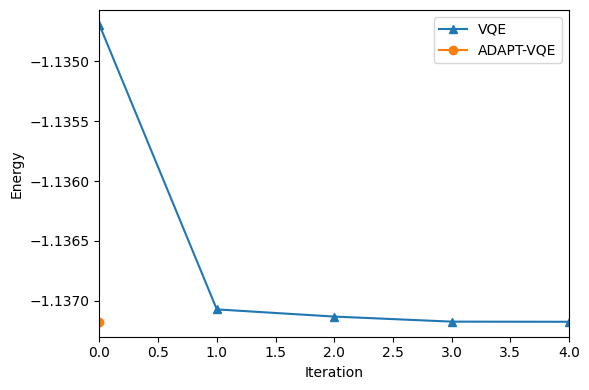

In [11]:
x_vqe   = np.arange(len(vqe_energies))     
x_adapt = np.arange(len(energies_adapt))    

plt.figure(figsize=(6, 4))
plt.plot(x_vqe,   vqe_energies,   '^-', label='VQE')
plt.plot(x_adapt, energies_adapt, 'o-', label='ADAPT-VQE')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.xlim(0, len(vqe_energies) - 1)         
plt.legend()
plt.tight_layout()
plt.show()

## Parallelizing ADAPT-VQE

In the future, data centers will host multiple QPUs, allowing quantum algorithms to parallelize and run faster. For example, obtaining one million circuit samples can be accomplished by pooling 100,000 samples from 10 QPUs. 

ADAPT-VQE is well suited to benefit from parallelization in a few parts of the code. In the next exercise, you will explore how this can speed up the runtime of ADAPT-VQE. 

Computing the commutators for the gradient in each ADAPT-VQE step is a trivially parallelizable task.  Each operator is independent of the others, so each one can be evaluated on a separate QPU.  CUDA-Q's MQPU backend allows you to simulate this by designating each circuit to run on a different virtual QPU simulated by a GPU.

Examine the code below to see how this is done.  Simply change the backend with `cudaq.set_target('nvidia', option='mqpu,fp64')` and `cudaq.observe` with `cudaq.observe_async` and add a variable `qpu_id` which specifies an integer corresponding to your index of available GPUs. These results are run asynchronously and stored in a list of futures which are then accessed later with `get()`.  One slight complication is when the initial set and subsequent states are obtained with `get_state`, they must also be updated to `get_state_async`.  You can no longer save the new state at the end of each new iteration as the `get_state_async` needs to run on the same `qpu_id` as the command computing the expectation value, otherwise the state will be prepared on a different GPU. 

**Exercise 5:**

Your task is to further parallelize the code and modify the `parameter_shift` function, which computes the gradient of the VQE step, to run asynchronously across two simulated QPUs.  Use the parallel code for the commutator evaluation as a guide for this. 

Next, add flags to capture the execution of the serial and parallel implementations.  Then, run them on LiH for a maximum of 5 steps (iterations).  Do you notice a difference?  You may not, and this is because the problem is too small to benefit from the overhead required to distribute the information across multiple simulated QPUs.  Increase the maximum number of steps to 15 and try again.  Now do you notice the difference?  The longer ADAPT-VQE runs, the harder each circuit evaluation and VQE procedure becomes, meaning there is greater benefit from using parallelization.  Similar to the fact that a GPU must be used for a problem large enough to benefit from parallelization, asynchronous execution across multiple QPUs will be most valuable when the individual tasks are harder. 


In [ ]:
cudaq.set_target('nvidia', option='mqpu,fp64')

start_time = time.time()
#geometry = [('O', (0., 0., 0.)), ('H', (-0.75, 0.5, 0.0)), ('H', (-0.75, -0.5, 0.0))] 
#geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.6))] 
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, ccsd=True, casci=True)

norbitals = molecule.n_orbitals
nelectrons = molecule.n_electrons
n_qubits= norbitals * 2

print(molecule.energies)

#Pulling commands from above so you can edit molecule and run this cell only
pools,word_pool,sign_pool = get_uccsd_pool(nelectrons, n_qubits)
grad_op = commutator(pools, molecule.hamiltonian)


from scipy.optimize import minimize

print('Beginning of ADAPT-VQE')

threshold=1e-3
E_prev=0.0
e_stop=1e-5
init_theta=0.0

energies_adapt.append(molecule.energies['hf_energy'])


theta_single=[]
theta_double=[]

pool_single=[]
pool_double=[]

coef_single=[]
coef_double=[]

selected_pool=[]

max_steps = 15

for i in range(max_steps):
    
    print('Step: ', i)

#-------------------------------------------------------------------   
    async_results =[]

    for i in range(len(grad_op)):
        qpu_id = i % 2 #paralellize across 2 GPUs
        if i == 0:
            state = cudaq.get_state_async(initial_state, n_qubits, nelectrons, qpu_id = qpu_id).get()
        else:
            state=cudaq.get_state_async(kernel, theta, n_qubits, nelectrons, pool_single,coef_single, pool_double, coef_double, qpu_id=qpu_id).get()
        
        async_results.append(cudaq.observe_async(psi, grad_op[i], state, qpu_id = qpu_id))

    gradient_vec = [res.get().expectation() for res in async_results]
    print(gradient_vec)
    
#-------------------------------------------------------------------   
    
    norm=np.linalg.norm(np.array(gradient_vec))
    print('Norm of the gradient: ', norm)


    
    if norm <= threshold:
        print('\n', 'Final Result: ', '\n')
        print('Final parameters: ', theta)
        print('Selected pools: ', selected_pool)
        print('Number of pools: ', len(selected_pool))
        print('Final energy: ', result_vqe.fun)
        
        break
    
    else:


        
        max_grad=np.max(np.abs(gradient_vec))
        print('max_grad: ', max_grad)
        
        temp_op = []
        temp_sign = []
        for i in range(len(word_pool)):
            if np.abs(gradient_vec[i]) == max_grad:
                temp_op.append(word_pool[i])
                temp_sign.append(sign_pool[i])
        
        selected_pool=selected
        
        print('Operator selected at current step: ', temp_op)


        tot_single=0
        tot_double=0
        for p in temp_op:
            if len(p) == 2:
                tot_single += 1
                for word in p:
                    pool_single.append(word)
            else:
                tot_double += 1
                for word in p:
                    pool_double.append(word)
                    
        for coef in temp_sign:
            if len(coef) == 2:
                for value in coef:
                    coef_single.append(value.real)
            else:
                for value in coef:
                    coef_double.append(value.real)
                    
        print('pool single: ', pool_single)
        print('coef_single: ', coef_single)
        print('pool_double: ', pool_double)
        print('coef_double: ', coef_double)
        print('tot_single: ', tot_single)
        print('tot_double: ', tot_double)

        init_theta_single = [init_theta] * tot_single
        init_theta_double = [init_theta] * tot_double
        
        theta_single = theta_single + init_theta_single
        theta_double = theta_double + init_theta_double
        
        print('theta_single', theta_single)
        print('theta_double: ', theta_double)
        
        theta = theta_single + theta_double
        print('theta', theta)

        def cost(theta):
            
            theta=theta.tolist()
            
            energy=cudaq.observe(kernel, molecule.hamiltonian, theta, n_qubits, nelectrons, pool_single, 
                                coef_single, pool_double, coef_double).expectation()
            
            return energy
        
        #TODO - Update the gradient computation to parallelize across two GPUs
        # Compute the gradient using parameter shift
        def parameter_shift(theta):
            parameter_count = len(theta)
            grad = np.zeros(parameter_count)
            theta2 = theta.copy()
            for i in range(parameter_count):
                theta2[i] = theta[i] + np.pi/4
                exp_val_plus = cudaq.observe(kernel, molecule.hamiltonian, theta2, n_qubits, nelectrons, pool_single, 
                                coef_single, pool_double, coef_double, #FIX_ME#).expectation().get()
                theta2[i] = theta[i] - np.pi/4
                exp_val_minus = cudaq.observe(kernel, molecule.hamiltonian, theta2, n_qubits, nelectrons, pool_single, 
                                coef_single, pool_double, coef_double, #FIX_ME#).expectation().get()
                grad[i] = (exp_val_plus - exp_val_minus)
                theta2[i] = theta[i]
        # TODO END

        
#-------------------------------------------------------------------
        #This section saves the optimized parameters, prints the energy and determines if the energy has converged.        
        result_vqe=minimize(cost, theta, method='BFGS', jac='parameter_shift',  options={'maxiter':100})

        theta=result_vqe.x.tolist()
        theta_single = theta[:tot_single]
        theta_double = theta[tot_single:]
        
        print('Optmized Energy: ', result_vqe.fun)
        print('Optimizer exited successfully: ',result_vqe.success, flush=True)
        print(result_vqe.message, flush=True)
        
        energies_adapt.append(result_vqe.fun)
        dE= result_vqe.fun-E_prev
        print('dE: ', dE)
        print('\n')
        
        if np.abs(dE)<=e_stop:
            print('\n', 'Final Result: ', '\n')
            print('Final parameters: ', theta)
            print('Selected pools: ', selected_pool)
            print('Number of pools: ', len(selected_pool))
            print('Final energy: ', result_vqe.fun)
            
            break
    
        else:

            E_prev=result_vqe.fun


end_time = time.time()

print(end_time-start_time)

{'nuclear_energy': 0.7080240981000804, 'hf_energy': -1.116325564486115, 'fci_energy': -1.1371757102406854}
Beginning of ADAPT-VQE
Step:  0
[0.0, 0.0, -0.36325066295313035]
Norm of the gradient:  0.36325066295313035
max_grad:  0.36325066295313035
Operator selected at current step:  [['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']]
pool single:  []
coef_single:  []
pool_double:  ['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']
coef_double:  [0.125, 0.125, 0.125, 0.125, -0.125, -0.125, -0.125, -0.125]
tot_single:  0
tot_double:  1
theta_single []
theta_double:  [0.0]
theta [0.0]
Optmized Energy:  -1.1371757102406856
Optimizer exited successfully:  True
Optimization terminated successfully.
dE:  -1.1371757102406856


Step:  1
[0.0, 0.0, 1.7096487003875893e-09]
Norm of the gradient:  1.7096487003875893e-09

 Final Result:  

Final parameters:  [0.11429722974759762]
Selected pools:  [['XXXY', 'XXYX', 'XYYY', 'YXYY', 'XYXX', 'YXXX', 'YYXY', 'YYYX']]
Number of 

## Conclusion

At this point, you have coded an ADAPT-VQE implementation of your own and explored specific parts of the workflow in detail like operator pool selection. There is great benefit in understanding the details, but often it is helpful to have an out-of-the-box implementation that is optimized and easy to plug into your larger workflow or ready to generate data for your research.  CUDA-Q Solvers provides easy to use ADAPT-VQE functions so you can produce the same results without the need to code at the kernel level. 

The code below, with just a few lines, runs the entire procedure coded above. You can easily swap out operator pools, molecules, and still run in parallel by following the instructions [outlined in the docs](https://nvidia.github.io/cudaqx/examples_rst/solvers/adapt.html).


In [13]:
cudaq.set_target('nvidia', option = 'fp64')
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, casci=True)

numElectrons = molecule.n_electrons

operators = solvers.get_operator_pool("spin_complement_gsd",num_orbitals=molecule.n_orbitals)

@cudaq.kernel
def initState(q: cudaq.qview):
    for i in range(numElectrons):
        x(q[i])

energy, thetas, ops = solvers.adapt_vqe(initState, molecule.hamiltonian,
                                        operators)

print("<H> = ", energy)

<H> =  -1.1371756814133405


ADAPT methods can also be generalized beyond chemistry and extend to problems like QAOA.  [This tutorial](https://nvidia.github.io/cuda-quantum/latest/applications/python/adapt_qaoa.html) in the CUDA-Q docs demonstrates how one can setup a QAOA problem and iteratively add layers where the mixer Hamiltonian is selected via the ADAPT process, leading to faster convergence. If you have completed the series [Divide-and-Conquer QAOA for MaxCut](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut), a good exercise might be to revisit your code and try improving it with it with ADAPT-QAOA. 

Though ADAPT methods have clear benefits over conventional variational algorithms, they still suffer from the same fundamental measurements problems and barren plateaus for large problem sizes. Nevertheless, they are fantastic drop-in substitutions for any situation where a variation method is used for a subroutine like state preparation. 

Generalizing beyond ADAPT methods, with this notebook you have learned how to use fundamental CUDA-Q functions like `exp_pauli`, `get_state_async` and `observe_async` as well as how to use a CUDA-Q Solvers method out-of-the box.  To learn more, visit the [CUDA-Q docs page](https://nvidia.github.io/cuda-quantum/latest/index.html) and the [CUDA-Q Solvers docs](https://nvidia.github.io/cudaqx/examples_rst/solvers/examples.html).
